In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import io

import h5py
import matplotlib.pyplot as plt
import numpy as np

import trimesh
from PIL import Image
import torch.nn

import glob
import os
import pickle
import time
import warnings
from typing import Any, Dict

import decord
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from PIL import Image
from decord import VideoReader, cpu
from skimage.transform import resize
from torch.utils.data import Dataset
from torch.utils.data import Dataset
from torchvision import transforms
from scipy.optimize import linear_sum_assignment
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Prepare Physion dataset

In [2]:

def get_image(raw_img, pil=False):
    '''
    raw_img: binary image to be read by PIL
    returns: HxWx3 image
    '''
    img = Image.open(io.BytesIO(raw_img))

    if pil:
        return img
    
    return np.array(img)

def get_num_frames(h5_file):
    return len(h5_file['frames'].keys())


def index_img(h5_file, index, suffix='', pil=False):

    # print(index)
    if index > len(h5_file['frames']) - 1:
        #set index to last frame
        # print("inside if")
        index = len(h5_file['frames']) - 1

    img0 = h5_file['frames'][str(index).zfill(4)]['images']
    
    rgb_img = get_image(img0['_img' + suffix][:], pil=pil)
    
    segments = np.array(get_image(img0['_id' + suffix][:]))

    return rgb_img, segments

def index_imgs(h5_file, indices, static=False, suffix='', pil=False):

    if not static:
        all_imgs = []
        all_segs = []
        for ct, index in enumerate(indices):
            rgb_img, segments = index_img(h5_file, index, suffix=suffix, pil=pil)
            all_imgs.append(rgb_img)
            all_segs.append(segments)
    else:
        rgb_img, segments = index_img(h5_file, indices[0])
        all_imgs = [rgb_img]
        all_segs = [segments]

        for ct, index in enumerate(indices[1:]):

            all_imgs.append(rgb_img)
            all_segs.append(segments)

    if not pil:
        all_imgs = np.stack(all_imgs, 0)
    all_segs = np.stack(all_segs, 0)
    
    return all_imgs, all_segs

def get_object_masks(seg_imgs, seg_colors, background=True):
    # if len(seg_imgs.shape) == 3:
    #     seg_imgs = np.expand_dims(seg_imgs, 0)
    #     is_batch = False
    # else:
    #     is_batch = True

    obj_masks = []
    for scol in seg_colors:
        mask = (seg_imgs == scol)#.astype(np.float)

        # If object is not visible in the frame
        # if mask.sum() == 0:
        #     mask[:] = 1
        obj_masks.append(mask)

    obj_masks = np.stack(obj_masks, 0)
    obj_masks = obj_masks.min(axis=-1)  # collapse last channel dim

    if background:
        bg_mask = ~ obj_masks.max(0, keepdims=True)
        obj_masks = np.concatenate([obj_masks, bg_mask], 0)
    obj_masks = np.expand_dims(obj_masks, -3)  # make N x 1 x H x W

    # if not is_batch:
    #     obj_masks = obj_masks[0]
    return obj_masks

class Physion(Dataset):

    def __init__(self, hdf5_path, gaps=[0, 450], shp=224, pad=30, transform=None,\
                 mask_per_object=False,\
                 index_start=None,\
                 full_video=True,\
                 start_zero=False,\
                 get_label=False):
        
        with h5py.File(hdf5_path) as f:
            features = f['features'][:, 0]
            filenames = f['filenames'][:]
#             print(filenames)
            
        self.all_hdf5 = filenames
        
        self.all_features = features

        self.full_video = full_video

        self.start_zero = start_zero

        self.mask_per_object = mask_per_object

        self.index_start = index_start

        np.random.shuffle(self.all_hdf5)

        self.get_label = get_label

        self.transform = transform

        self.background = True

        self.gaps = np.array(gaps)

        self.n_frames_gap = self.gaps // 10

        self.shp = shp

        self.pad = pad

    def __len__(self):
        # return 1
        return len(self.all_hdf5)

    def __getitem__(self, idx):
        # breakpoint()

        filename = self.all_hdf5[idx]
        
        features = self.all_features[idx]
        
        n_patches = np.sqrt(features.shape[0]).astype('int')
        
        features = features.reshape(n_patches, n_patches, -1)

        # print()
        # print(filename)
        with h5py.File(filename, 'r') as h5_file:
#             print(h5_file.keys())
            num_frames = get_num_frames(h5_file)

            if self.n_frames_gap[-1] >= num_frames:
                second_frame = num_frames - 1
            else:
                second_frame = self.n_frames_gap[-1]

            if self.index_start is None:
                index_start = np.random.randint(0, num_frames - second_frame)
                if self.full_video:
#                     print("in full video")
                    index_start = 30
                    if self.start_zero:
                        index_start = 0
                    if 'collide' in filename.decode():
                        # print("file is collide", filename)
                        index_start = 0
            else:
                mx = num_frames - second_frame
                index_start = np.random.randint(int(self.index_start*num_frames), mx - int(mx*self.index_start))

            indices = []
            for ind in self.n_frames_gap[:-1]:
                indices.append(index_start + ind)

            indices.append(index_start + second_frame)

            #convert to numpy array
            indices = np.array(indices)

            # print(indices)

            rgb_imgs, seg_imgs = index_imgs(h5_file, indices, suffix='_cam0', pil=True)
            seg_colors = h5_file['static']['object_segmentation_colors'][:]
            
            m_names = np.array(h5_file['static']['model_names'])
            occluders = np.array(h5_file['static']['occluders'])
            distractors = np.array(h5_file['static']['distractors'])

        obj_masks = get_object_masks(seg_imgs, seg_colors, self.background)  # O x N x 1 x H x W
        obj_masks = obj_masks.transpose([1, 0, 2, 3, 4])  # N x O x 1 x H x W

        ret = {}

        image_list = [np.array(x.resize((self.shp, self.shp))) for x in rgb_imgs]
        
        image_list = np.stack(image_list, 0)
        
        
        image_tensor = image_list #image_tensor.view(len(image_list),  # num_frames
#                                          3,  # num_channels
#                                          *image_tensor.shape[-2:])


#         image_tensor = image_tensor.transpose(0, 1)

        timestamps = self.gaps / (self.gaps[-1] + 1e-100)

        ret['video'] = image_tensor
        ret['seg_colors'] = seg_imgs

#         ret['mask'] = mask

        # breakpoint()

        ret['obj_masks'] = obj_masks[:, :, 0].transpose([1, 0, 2, 3])

        ret['obj_masks'] = resize(ret['obj_masks'],
                                  (ret['obj_masks'].shape[0], ret['obj_masks'].shape[1], self.shp, self.shp))



        if ret['obj_masks'].shape[0] < self.pad:
            ret['obj_masks'] = \
                np.concatenate([ret['obj_masks'], \
                                np.zeros([self.pad - ret['obj_masks'].shape[0], *ret['obj_masks'].shape[1:]]).astype(
                                    'bool')])


        ret['video_ts'] = timestamps

        ret['filename'] = filename
        
        ret['feature'] = features

        if self.get_label:
            ret['label'] = get_label(filename)

        # breakpoint()

        return ret

times = [0]

physion_datset = Physion(gaps=times,\
                         hdf5_path='/ccn2/u/rmvenkat/data/test_with_keypoint_model_3_feats/M4/train_features.hdf5',
                        full_video=True)

ret = physion_datset[0]

5608


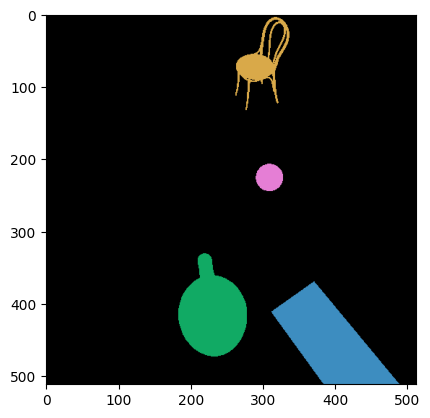

In [3]:
print(len(physion_datset))
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(ret['seg_colors'][0])

# Define Hungarian mask loss and focal loss

In [4]:
def batch_dice_loss(inputs: torch.Tensor, targets: torch.Tensor):
    """
    Compute the DICE loss, similar to generalized IOU for masks
    Args:
        inputs: A float tensor of shape [B, N, HW].
                The predictions for each example.
        targets: A float tensor with shape [B, M, HW]. Stores the binary
                 classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
    """
    inputs = inputs.sigmoid()
    numerator = 2 * torch.einsum("bnc,bmc->bnm", inputs, targets)
    denominator = inputs.sum(-1)[:, :, None] + targets.sum(-1)[:, None, :]
    loss = 1 - (numerator + 1) / (denominator + 1)
    return loss


def batch_sigmoid_ce_loss(inputs: torch.Tensor, targets: torch.Tensor):
    """
    Args:
        inputs: A float tensor shape [B, N, HW].
                The predictions for each example.
        targets: A float tensor with shape [B, M, HW]. Stores the binary
                 classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
    Returns:
        Loss tensor
    """
    hw = inputs.shape[-1]

    pos = F.binary_cross_entropy_with_logits(
        inputs, torch.ones_like(inputs), reduction="none"
    )
    neg = F.binary_cross_entropy_with_logits(
        inputs, torch.zeros_like(inputs), reduction="none"
    )

    loss = torch.einsum("bnc,bmc->bnm", pos, targets) + torch.einsum("bnc,bmc->bnm", neg, (1 - targets))

    return loss / hw

def batch_hungarian_matcher(cost_matrix):
    """
    Args:
        cost_matrix: a float tensor of shape [B, N, M]

    Returns:
        indices assignment
    """
    B = cost_matrix.shape[0]
    indices = []
    for i in range(B):
        indices.append(np.stack(linear_sum_assignment(cost_matrix[i]), axis=-1))
    
    match_idx = torch.tensor(np.stack(indices, 0))
    batch_idx = torch.arange(B).view(B, 1, 1).expand(-1, match_idx.shape[1], -1)
    idx = torch.cat([batch_idx, match_idx], dim=-1)
    return idx

# Prepare for training

In [5]:
# Define the decoder MLP
num_predicted_masks = 10
num_hidden_layers = 1
hidden_dim = 64

decoder_layers = [torch.nn.Linear(256, 64), torch.nn.ReLU()]
for i in range(num_hidden_layers):
    decoder_layers.append(torch.nn.Linear(hidden_dim, hidden_dim))
    decoder_layers.append(torch.nn.ReLU())
decoder_layers.append(torch.nn.Linear(64, num_predicted_masks))

decoder = torch.nn.Sequential(*decoder_layers).cuda()

# Hyperparameters
size = (64, 64)

# Optimizer
lr = 1e-4
optimizer = torch.optim.AdamW(decoder.parameters(), lr=lr)

# Dataloader
class MultiEpochsDataLoader(torch.utils.data.DataLoader):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._DataLoader__initialized = False
        self.batch_sampler = _RepeatSampler(self.batch_sampler)
        self._DataLoader__initialized = True
        self.iterator = super().__iter__()

    def __len__(self):
        return len(self.batch_sampler.sampler)

    def __iter__(self):
        for i in range(len(self)):
            yield next(self.iterator)


class _RepeatSampler(object):
    """ Sampler that repeats forever.
    Args:
        sampler (Sampler)
    """

    def __init__(self, sampler):
        self.sampler = sampler

    def __iter__(self):
        while True:
            yield from iter(self.sampler)


train_dataloader = MultiEpochsDataLoader(physion_datset, batch_size=128, shuffle=True, num_workers=64)
total_steps = len(train_dataloader)

# Num epochs 
num_epochs = 100

# Start training

In [ ]:
start = time.time()

for epoch_num in range(num_epochs):
    for i, batch in enumerate(train_dataloader):
        data_time = time.time() - start

        # Features
        seg_color = torch.tensor(batch['feature']).squeeze(1) # [B, H, W, 3]
        feature = F.interpolate(seg_color.permute(0, 3, 1, 2), size=size).cuda().permute(0, 2, 3, 1) # [B, h, w, 3]

        # Targets
        obj_mask = torch.tensor(batch['obj_masks']).float().squeeze(2)
        target = F.interpolate(obj_mask, size=size, mode='nearest').cuda().flatten(2, 3) # [B, M, hw]

        # Forward pass through the decoder
        logit = decoder(feature).permute(0, 3, 1, 2).flatten(2, 3) # [B, N, hw]
        
        # Compute pairwise cost 
        valid = target.sum(-1)[:, None].expand(-1, logit.shape[1], -1) == 0
        dice_cost = batch_dice_loss(logit, target)
        f1_cost = batch_sigmoid_ce_loss(logit, target)
        cost = dice_cost + f1_cost # [B, N, W]
        cost[valid] = 1e6
        
        # Hungarian matching
        match_idx = batch_hungarian_matcher(cost.cpu().detach()).permute(2, 0, 1) # [3, B, N]
        loss_list = loss = cost[list(match_idx)]
        valid = loss_list < 1e6
        
        # Compute loss value after matching
        loss = (loss * valid).sum() / (valid.sum() + 1e-6)
        

        # Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print loss value and measure time
        step_time = time.time() - start
        
        if (i + 1) == total_steps:                
            print(f'Epoch:{epoch_num}, Step:{i}/{total_steps}, Loss:{loss:.5f}, data_time:{data_time:.2f}, step_time:{step_time:.2f}')
        start = time.time()
    
    # Save model
    torch.save(decoder.state_dict(), 'linear_decoder.pt')


/tmp/ipykernel_1550704/2542891541.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  seg_color = torch.tensor(batch['feature']).squeeze(1) # [B, H, W, 3]
/tmp/ipykernel_1550704/2542891541.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obj_mask = torch.tensor(batch['obj_masks']).float().squeeze(2)


Epoch:0, Step:43/44, Loss:1.29517, data_time:0.06, step_time:0.50
Epoch:1, Step:43/44, Loss:1.12401, data_time:0.10, step_time:0.44
Epoch:2, Step:43/44, Loss:1.04614, data_time:0.06, step_time:0.41
Epoch:3, Step:43/44, Loss:1.04885, data_time:0.07, step_time:0.63
Epoch:4, Step:43/44, Loss:1.04089, data_time:0.07, step_time:0.51
Epoch:5, Step:43/44, Loss:1.01668, data_time:0.08, step_time:0.53
Epoch:6, Step:43/44, Loss:1.02045, data_time:0.08, step_time:0.46


In [9]:
feature.shape

torch.Size([128, 64, 64, 256])

# After training: evaluate mIoU and Visualize predictions

In [6]:
def batch_iou(inputs: torch.Tensor, targets: torch.Tensor):
    """
    Compute the iou, similar to generalized IOU for masks
    Args:
        inputs: A float tensor of shape [B, N, HW].
                The predictions for each example.
        targets: A float tensor with shape [B, M, HW]. Stores the binary
                 classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
    """
    numerator = torch.einsum("bnc,bmc->bnm", inputs, targets)
    denominator = ((inputs[:, :, None] + targets[:, None, :]) > 0).sum(-1) + 1e-6
    iou = numerator / denominator
    return iou

In [7]:
# Note: Evaluation requires Batch Size = 1

# physion_datset = Physion(gaps=times,\
#                          hdf5_path='/ccn2/u/rmvenkat/data/test_with_keypoint_model_3_feats/M4/test_features.hdf5')


train_dataloader = MultiEpochsDataLoader(physion_datset, batch_size=1, shuffle=True, num_workers=64)
decoder.load_state_dict(torch.load('linear_decoder.pt'))

<All keys matched successfully>

/tmp/ipykernel_1515539/824600103.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  seg_color = torch.tensor(batch['feature']).squeeze(1) # [B, H, W, 3]
/tmp/ipykernel_1515539/824600103.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obj_mask = torch.tensor(batch['obj_masks']).float().squeeze(2)


Image: 0, mIoU:0.202137


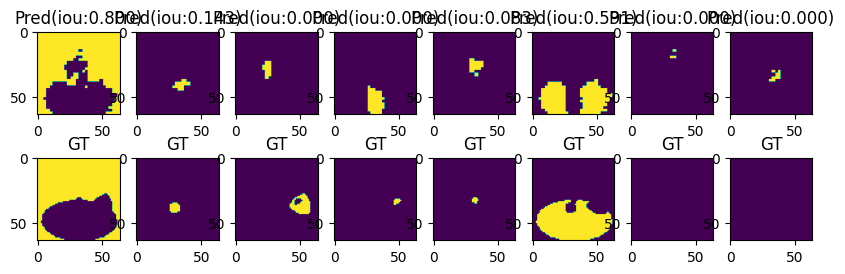

Image: 1, mIoU:0.081493


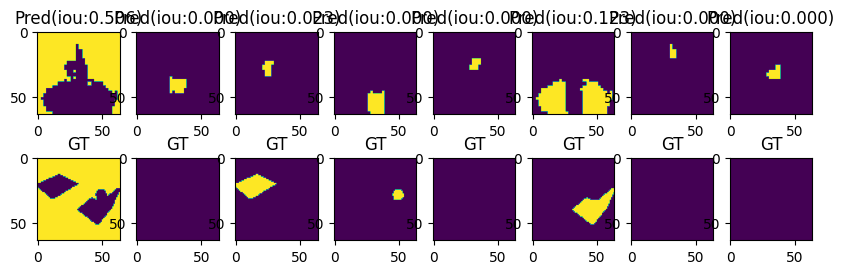

Image: 2, mIoU:0.079938


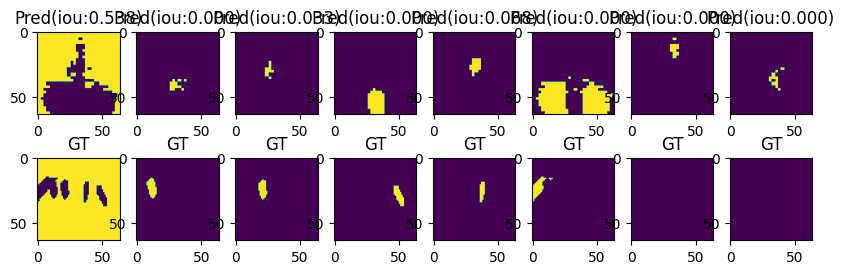

Image: 3, mIoU:0.192634


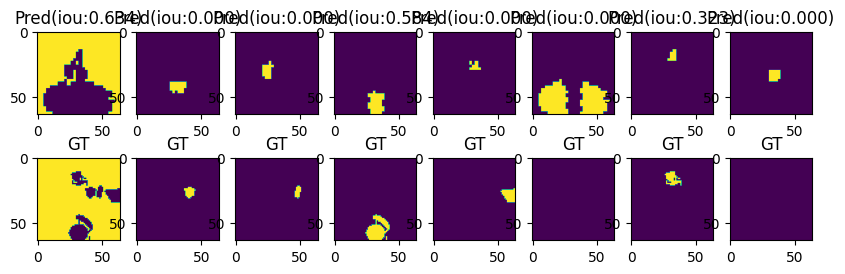

Image: 4, mIoU:0.094598


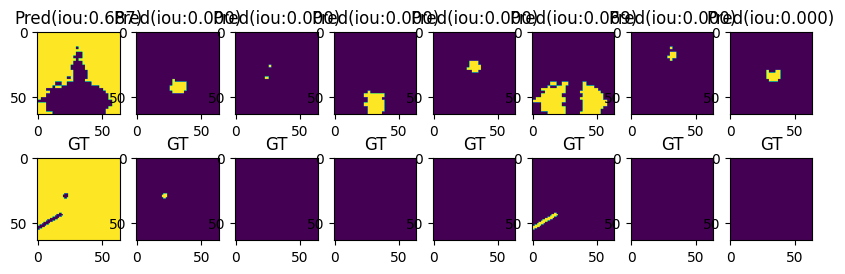

Image: 5, mIoU:0.263607


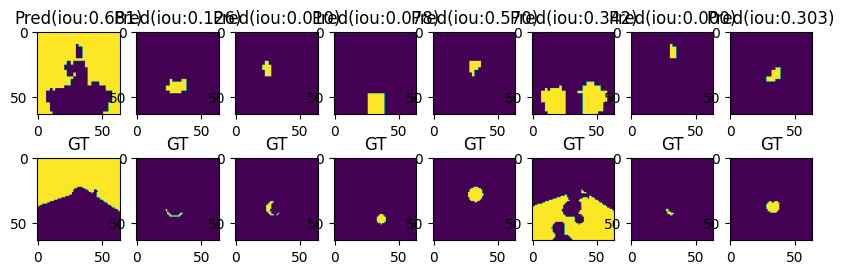

Image: 6, mIoU:0.206052


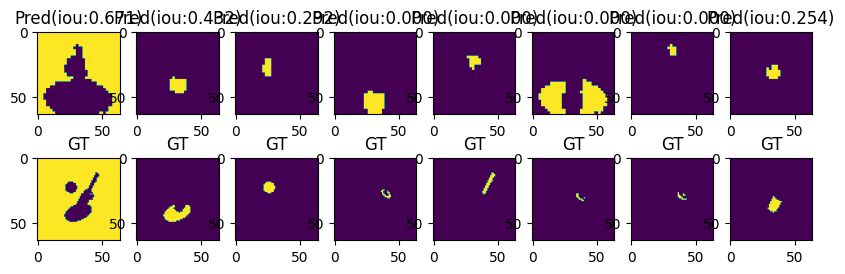

Image: 7, mIoU:0.206551


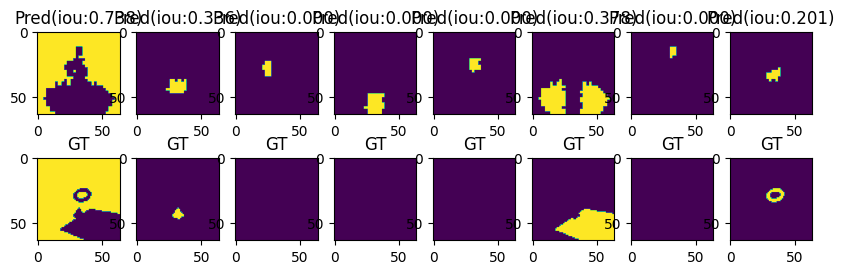

Image: 8, mIoU:0.277650


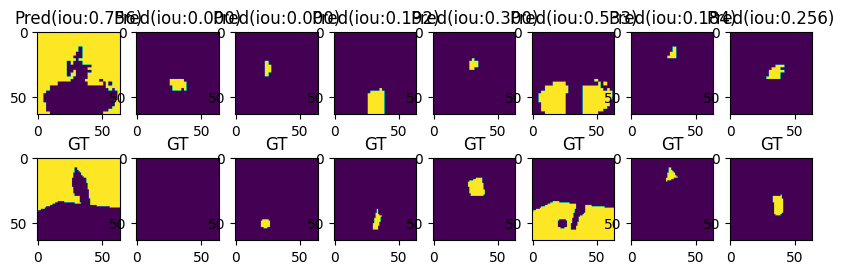

Image: 9, mIoU:0.177128


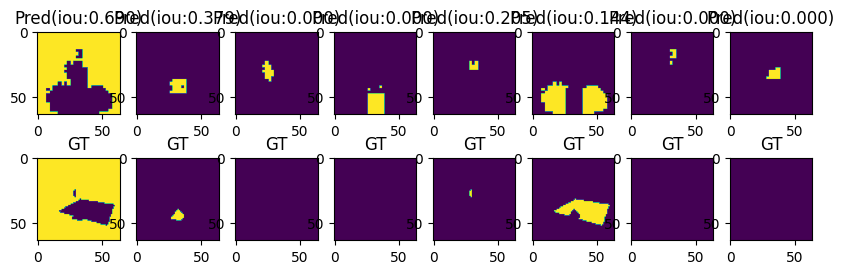

Image: 10, mIoU:0.180829


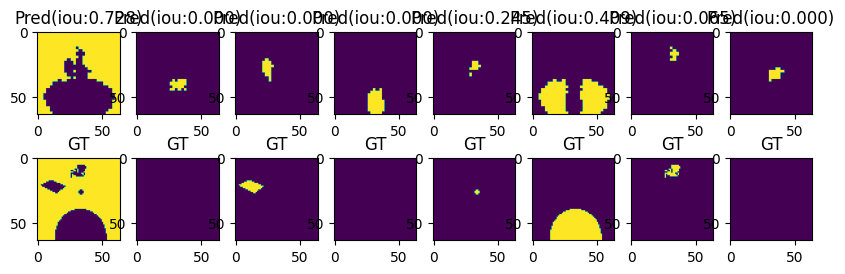

Image: 11, mIoU:0.114192


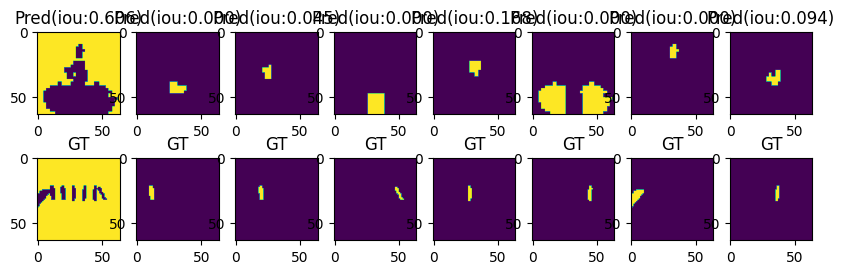

Image: 12, mIoU:0.275561


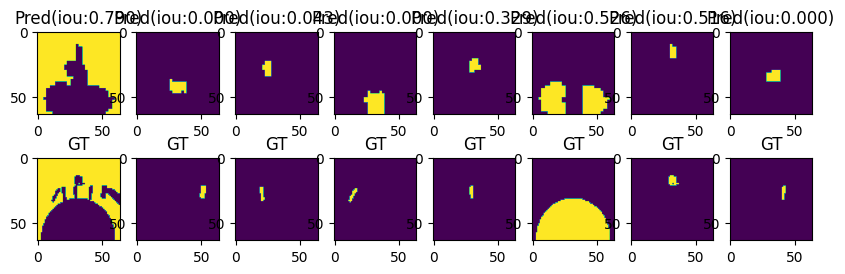

Image: 13, mIoU:0.191343


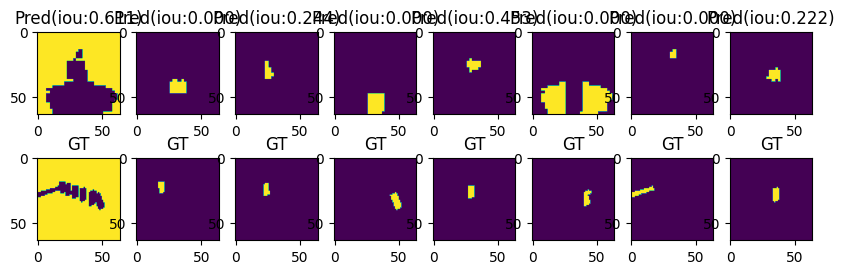

Image: 14, mIoU:0.126297


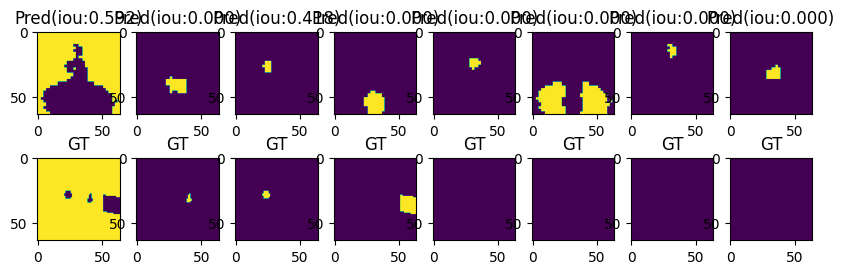

Image: 15, mIoU:0.227177


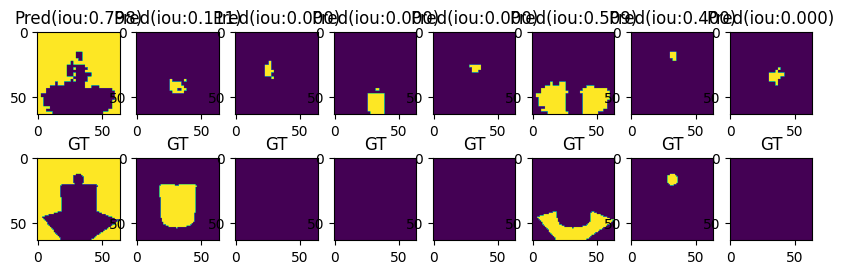

Image: 16, mIoU:0.105236


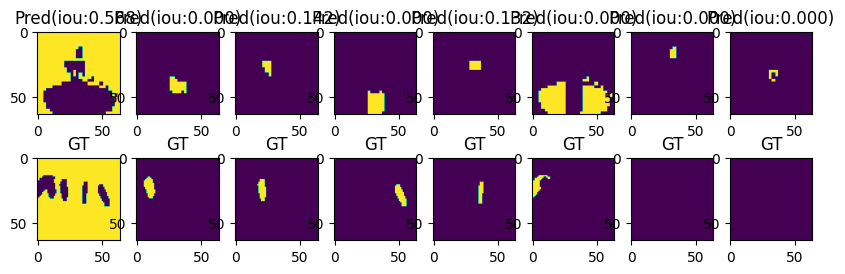

Image: 17, mIoU:0.344201


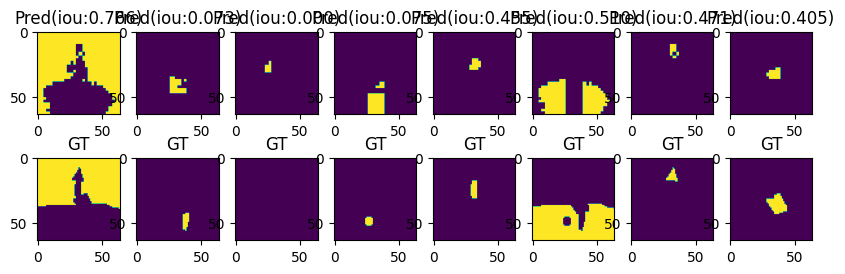

Image: 18, mIoU:0.206612


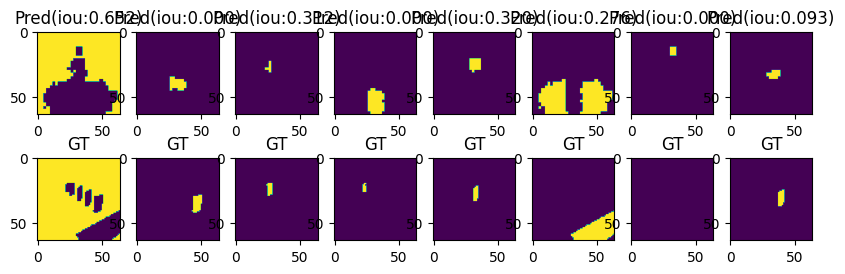

Image: 19, mIoU:0.354184


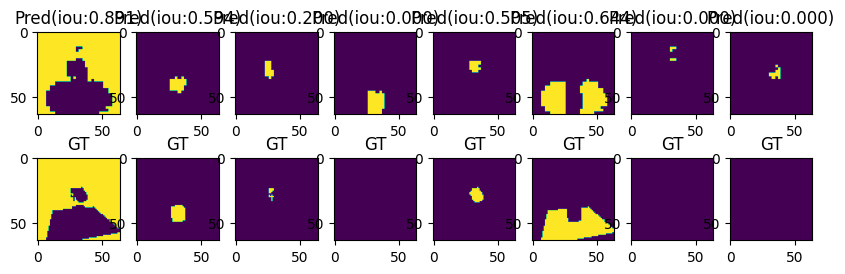

Image: 20, mIoU:0.300658


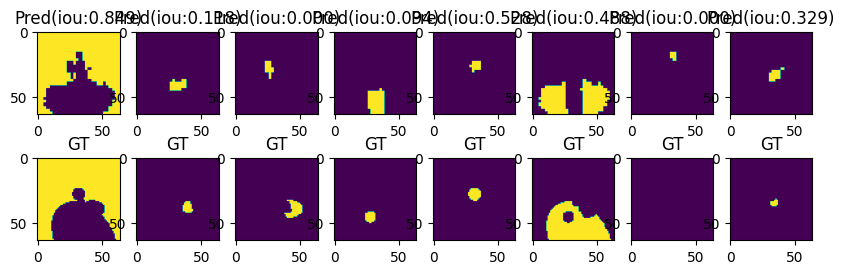

Image: 21, mIoU:0.304365


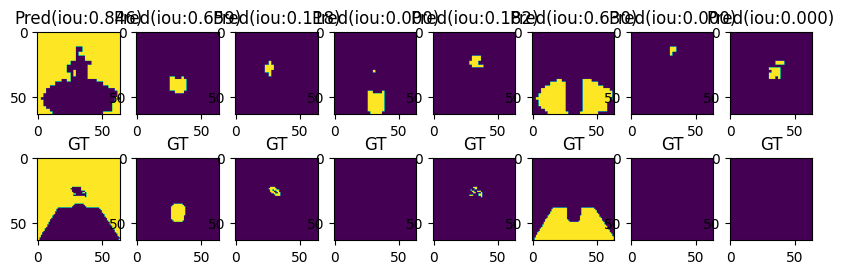

Image: 22, mIoU:0.090125


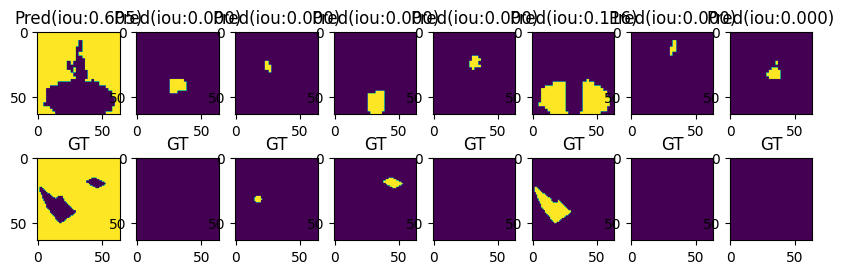

Image: 23, mIoU:0.231057


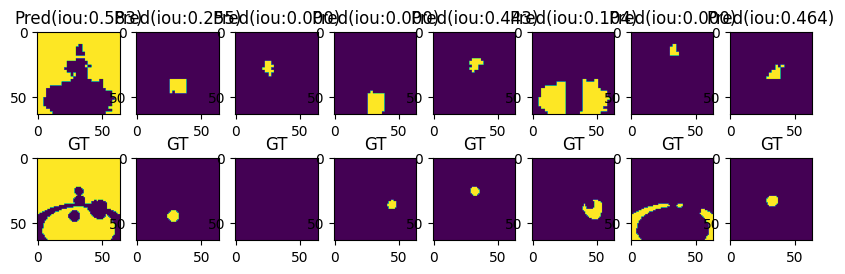

Image: 24, mIoU:0.224750


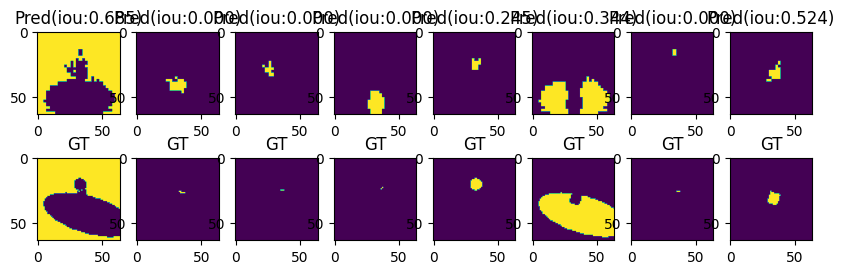

Image: 25, mIoU:0.231575


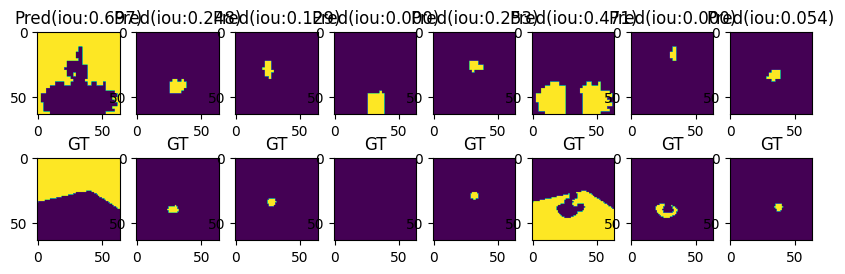

Image: 26, mIoU:0.344674


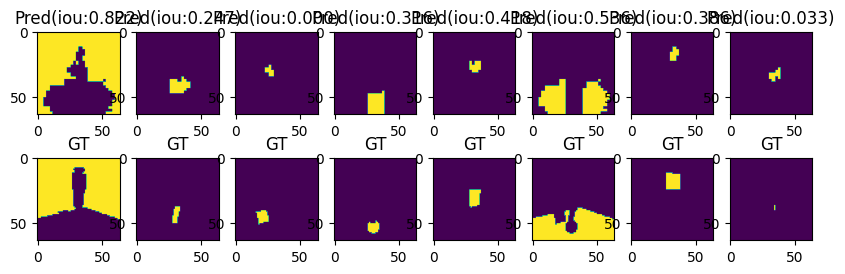

Image: 27, mIoU:0.315605


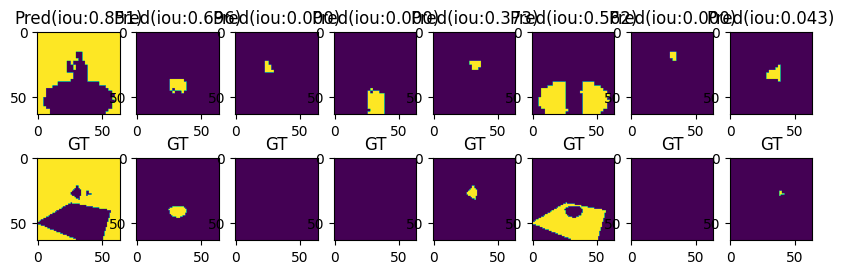

Image: 28, mIoU:0.278452


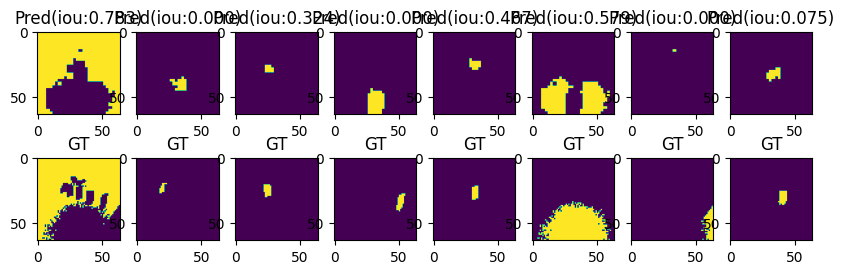

Image: 29, mIoU:0.204545


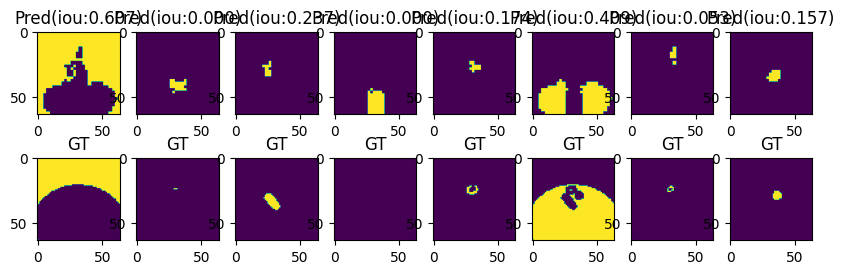

Image: 30, mIoU:0.251769


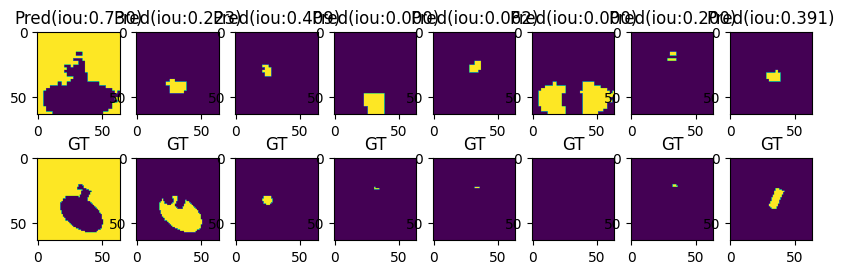

Image: 31, mIoU:0.093332


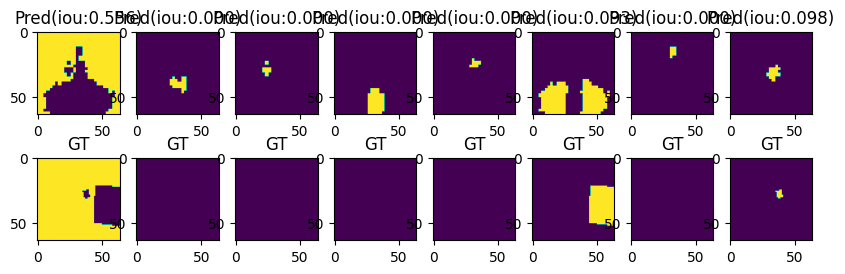

Image: 32, mIoU:0.264443


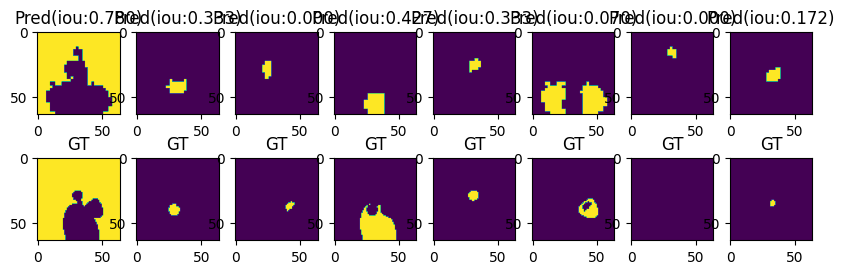

Image: 33, mIoU:0.154244


KeyboardInterrupt: 

In [9]:
start = time.time()
mean_iou_list = []
for i, batch in enumerate(train_dataloader):
    data_time = time.time() - start
    
    # Features (TODO: Rahul)
    seg_color = torch.tensor(batch['feature']).squeeze(1) # [B, H, W, 3]
    feature = F.interpolate(seg_color.permute(0, 3, 1, 2), size=size).cuda().permute(0, 2, 3, 1) # [B, h, w, 3]

    # Targets
    obj_mask = torch.tensor(batch['obj_masks']).float().squeeze(2)
    target = F.interpolate(obj_mask, size=size, mode='nearest').cuda().flatten(2, 3) # [B, M, hw]

    # Decode
    logit = decoder(feature).permute(0, 3, 1, 2).flatten(2, 3) # [B, N, hw]
    pred = logit.sigmoid().argmax(1)
    unique = pred.unique().view(1, -1, 1)
    pred = (pred[:, None] == unique).float()
    
    assert pred.shape[0] == 1, "only implement for batch size 1"
    
    iou_cost = batch_iou(pred, target)
    
    cost = 1-iou_cost # [B, N, W]
    
    match_idx = batch_hungarian_matcher(cost.cpu().detach()).permute(2, 0, 1) # [3, B, N]
    iou_list = iou_cost[list(match_idx)]
    mean_iou = iou_list.mean()
    mean_iou_list.append(mean_iou)
    print(f'Image: {i}, mIoU:{mean_iou:4f}')
    
    
    batch_idx = 0
    fig, axs = plt.subplots(2, match_idx.shape[-1], figsize=(10, 3))
    for j in range(match_idx.shape[-1]):
        _, nidx, midx = match_idx[:, batch_idx, j]
        _iou = iou_list[batch_idx, j]
        p = pred[batch_idx, nidx].view(64,64).cpu().detach().bool()
        t = target[batch_idx, midx].view(64,64).cpu().detach().bool()
        axs[0, j].imshow(p)
        axs[1, j].imshow(t)
        axs[0, j].set_title(f'Pred(iou:{_iou:.3f})')
        axs[1, j].set_title(f'GT')
    plt.show()

        
mean_iou = torch.mean(torch.stack(mean_iou_list))
print('===' * 12)
print('Final Mean IoU: ', mean_iou.item())